## main takeways from this

The ignition delay becomes negligble when the temperature of the gas is around 1600K, which would be the temperature of a general butane lighter, therefore these simulations are not really necessary. THIS IS AT STOICHIOMETRIC CONDITIONS for propane and ox. 

In [1]:
import pandas as pd
import numpy as np

import time

import cantera as ct

print(f"Runnning Cantera version: {ct.__version__}")

import matplotlib.pyplot as plt

Runnning Cantera version: 3.0.0


In [2]:
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 120

plt.style.use("ggplot")

In [29]:
# Define gas mixture with gri30 mechanism file, set to stoichiometric reaction
gas = ct.Solution('gri30.yaml')

# Define the reactor temperature and pressure
reactor_temperature = 1600  # Kelvin
reactor_pressure = 101325*5  # Pascals
gas.TP = reactor_temperature, reactor_pressure
    
# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel="C3H8", oxidizer={"O2": 5.0})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
reactor_network = ct.ReactorNet([r])

# use the above list to create a DataFrame
time_history = ct.SolutionArray(gas, extra="t")

In [30]:
def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurrence of the
    peak in species' concentration.
    """
    # Get the concentrations of the specified species
    species_concentration = states(species).Y

    # Check if the species concentration array is empty
    if species_concentration.size == 0:
        raise ValueError(f"No data found for species '{species}'. Ignition delay cannot be computed.")
    
    # If not empty, proceed to find the index of the maximum concentration
    i_ign = species_concentration.argmax()
    return states.t[i_ign]

In [33]:
reference_species = "OH"

# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 1
t = 0

counter = 1
while t < estimated_ignition_delay_time:
    t = reactor_network.step()
    if not counter % 10:
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(r.thermo.state, t=t)
    counter += 1

# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)

# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.7f} seconds. Took {t1-t0:3.2f}s to compute")

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# time_history.to_csv("time_history.csv")

Computed Ignition Delay: 0.0000046 seconds. Took 0.00s to compute


Text(0, 0.5, '$Y_{OH}$')

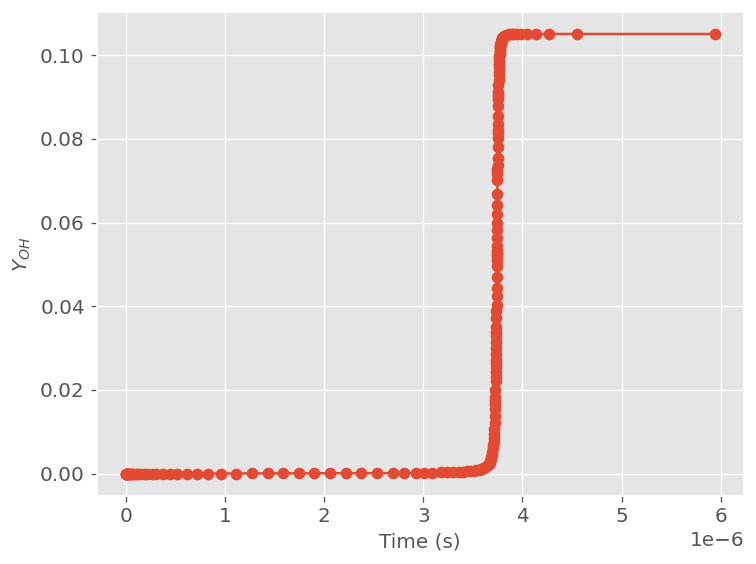

In [34]:
plt.figure()
plt.plot(time_history.t, time_history(reference_species).Y, "-o")
plt.xlabel("Time (s)")
plt.ylabel("$Y_{OH}$")

In [12]:
# Make a list of all the temperatures we would like to run simulations at
T = np.hstack((np.arange(1800, 900, -100), np.arange(975, 475, -25)))

estimated_ignition_delay_times = np.ones_like(T, dtype=float)

# Make time adjustments for the highest and lowest temperatures. This we do empirically
estimated_ignition_delay_times[:6] = 6 * [0.1]
estimated_ignition_delay_times[-4:-2] = 10
estimated_ignition_delay_times[-2:] = 100

# Now create a SolutionArray out of these
ignition_delays = ct.SolutionArray(
    gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times}
)
ignition_delays.set_equivalence_ratio(
    1.0, fuel="C3H8", oxidizer={"o2": 5.0}
)
ignition_delays.TP = T, reactor_pressure


In [13]:
for i, state in enumerate(ignition_delays):
    # Setup the gas and reactor
    gas.TPX = state.TPX
    r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])

    reference_species_history = []
    time_history = []

    t0 = time.time()

    t = 0
    while t < estimated_ignition_delay_times[i]:
        t = reactor_network.step()
        time_history.append(t)
        reference_species_history.append(gas[reference_species].X[0])

    i_ign = np.array(reference_species_history).argmax()
    tau = time_history[i_ign]
    t1 = time.time()

    print(
        f"Computed Ignition Delay: {tau:.3e} seconds for T={state.T}K. Took {t1 - t0:3.2f}s to compute"
    )

    ignition_delays[i].tau = tau

Computed Ignition Delay: 4.655e-06 seconds for T=3522.464326266611K. Took 0.11s to compute
Computed Ignition Delay: 6.882e-06 seconds for T=3518.2284774218792K. Took 0.10s to compute
Computed Ignition Delay: 1.162e-05 seconds for T=3514.5283862982915K. Took 0.11s to compute
Computed Ignition Delay: 2.403e-05 seconds for T=3511.454153336082K. Took 0.10s to compute
Computed Ignition Delay: 6.679e-05 seconds for T=3509.114604623671K. Took 0.11s to compute
Computed Ignition Delay: 2.733e-04 seconds for T=3507.642402821809K. Took 0.12s to compute
Computed Ignition Delay: 1.674e-03 seconds for T=3507.20113065749K. Took 0.14s to compute
Computed Ignition Delay: 1.384e-02 seconds for T=3507.9953807623233K. Took 0.15s to compute
Computed Ignition Delay: 1.296e-01 seconds for T=3510.2855864084277K. Took 0.17s to compute
Computed Ignition Delay: 2.285e-01 seconds for T=3511.1325037671495K. Took 0.18s to compute
Computed Ignition Delay: 4.051e-01 seconds for T=3512.105842987351K. Took 0.17s to com

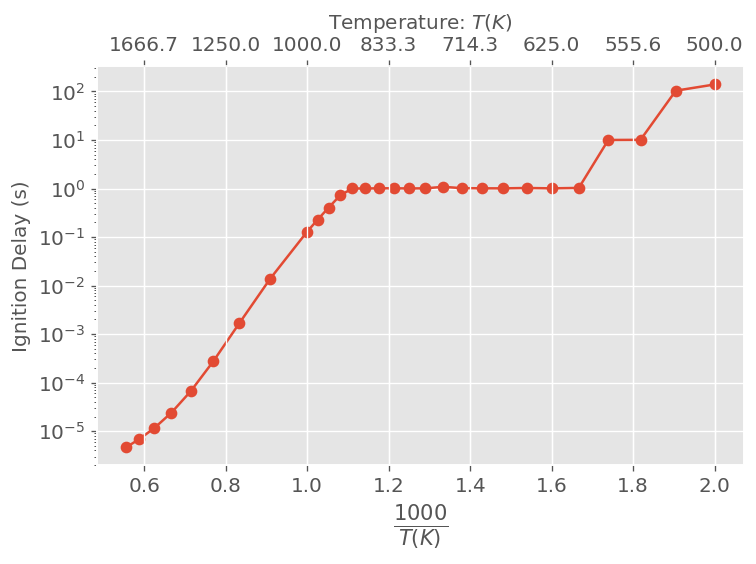

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000 / ignition_delays.T, ignition_delays.tau, "o-")
ax.set_ylabel("Ignition Delay (s)")
ax.set_xlabel(r"$\frac{1000}{T (K)}$", fontsize=18)

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature: $T(K)$");